# Measure Predicted Changes in Phase Diagrams
Given a list of compounds that are predicted to be stable by Dipendra's DL model, measure changes in the phase diagrams.

In [1]:
%matplotlib inline
from pymatgen import Composition, Element
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.plotter import PDPlotter
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.phasediagram.analyzer import PDAnalyzer
import itertools
import os
import re
import pandas as pd

## Load in the OQMD data

In [2]:
oqmd_data = pd.read_csv('oqmd_all.txt', delim_whitespace=True)
print('Read in %d entries'%len(oqmd_data))

Read in 506114 entries


C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rename `comp` to `composition` (you'll thank me later)

In [3]:
oqmd_data.rename(columns={'comp':'composition'}, inplace=True)
oqmd_data.head()

,composition,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.892,17.8351,None,0.0,0.015186,0.0151862666667
1,Mg1,-1.5396,22.9639,None,0.0,0.002912,0.0029123775
2,Kr1,0.011256,41.4146,None,7.367,0.015315,0.015314775
3,Na1,-1.2991,32.9826,None,0.0,0.003780,0.00377956333333
4,Pd1,-5.15853,15.2088,None,0.0,0.018186,0.0181856433333


Eliminate entries with no `delta_e`

In [4]:
oqmd_data = oqmd_data[~ oqmd_data['delta_e'].isnull()]
print('%d entries with delta_e'%len(oqmd_data))

506114 entries with delta_e


Eliminate insanely low formation enthalpies

In [5]:
oqmd_data = oqmd_data.query('delta_e > -10')

In [6]:
oqmd_data.describe()

,delta_e
count,506113.000000
mean,-0.072298
std,2.306472
min,-5.620103
25%,-0.312292
50%,0.066099
75%,0.395459
max,1126.312155


Convert this data to PDEntries. This is what `pymatgen`'s PhaseDiagram creates

In [7]:
%%time
def get_pdentry(row, attribute=None):
    comp = Composition(row['composition'])
    return PDEntry(comp.fractional_composition, row['delta_e'], comp.reduced_formula, attribute)
oqmd_data['pdentry'] = oqmd_data.apply(lambda x: get_pdentry(x, 'oqmd'), axis=1)

Wall time: 1min 53s


List out the system for each entry

In [8]:
elem_re = re.compile('[A-Z][a-z]?')
def get_elems(s):
    return ''.join(sorted(set(elem_re.findall(s))))
assert get_elems('AlFeFe2') == 'AlFe'
oqmd_data['system'] = oqmd_data['composition'].apply(get_elems)

Make a function to get data from a single system

In [9]:
def get_data_from_system(data, system):
    """Extract rows from a pandas array that are in a certain phase diagram
    
    :param data: DataFrame, data from which to query. Must contain column "system"
    :param system: list/set, list of elements to serve as input
    :return: DataFrame, with only entries that exclusively contain these elements"""
    
    # Get the systems that make up this phase diagram
    constit_systems = set()
    for sys in itertools.product(system, repeat=len(system)):
        constit_systems.add(''.join(sorted(set(sys))))
    
    # Get all points that are at any of those systems
    query_str = ' or '.join(['system == "%s"'%s for s in constit_systems])
    return data.query(query_str)
    
assert set(get_data_from_system(oqmd_data, ['Al','Ni','Zr'])['system']) == {'Al', 'Ni', 'Zr', 'AlNi', 'AlZr', 'NiZr', 'AlNiZr'}

Plot one of the ternary diagrams. This chart shows the compositions of stable phases in the Te-Ni-Hf system. Stable phases are those on the convex hull.

C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\numpy\linalg\linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


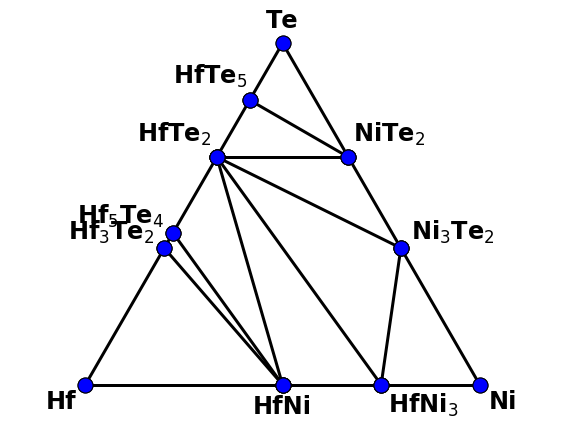

In [10]:
pdg = PhaseDiagram(get_data_from_system(oqmd_data, ['Te', 'Ni', 'Hf'])['pdentry'])
PDPlotter(pdg).show()

### Compute the number of stable entries in each phase diagram
This is our "baseline" measurement for what the diagrams look like before deep learning

#### Get the lists of systems to search
Counting the number of stable phases in each system could take a very 

In [11]:
element_list = set()
oqmd_data['composition'].apply(lambda x: element_list.update(elem_re.findall(x)))
print('Number of elements:', len(element_list))

Number of elements: 89


Get certain groups of elements

In [12]:
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe']
alkali_metals = ['Li', 'Na', 'K'] # , 'Rb', 'Cs'] - Only do the common ones
threed_tms = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']
actinides = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu'] # VASP only has these
lanthanides = [Element.from_Z(x).symbol for x in range(57, 72)]

Remove noble gases, lanthanides, and actinides

In [13]:
element_list.difference_update(noble_gases)
element_list.difference_update(actinides)
element_list.difference_update(lanthanides)
print('Number of elements:', len(element_list))

Number of elements: 63


Get all of the binary systems

In [14]:
def assemble_list_of_systems(order):
    """Create a DataFrame of all possible systems with a certain number of elements"""
    output = pd.DataFrame()
    output['system'] = list(itertools.combinations(element_list, order))
    return output
binary_systems = assemble_list_of_systems(2)
print('Generated %d binary systems'%len(binary_systems))

Generated 1953 binary systems


Get the ternary systems that contain an common Alkali metal

In [15]:
ternary_systems = assemble_list_of_systems(3)
ternary_systems = ternary_systems[[any([x in s for x in alkali_metals]) for s in ternary_systems['system']]]
print('Generated %d ternary systems'%len(ternary_systems))

Generated 5491 ternary systems


Get quarternary systems that contain at least 3 3d TMs

LW 2June17: I made these filters stringent to keep runtimes down.

In [16]:
quaternary_systems = assemble_list_of_systems(4)
quaternary_systems = quaternary_systems[[sum([x in s for x in threed_tms]) >= 3 for s in quaternary_systems['system']]]
print('Generated %d quaternary systems'%len(quaternary_systems))

Generated 6570 quaternary systems


#### Count the number of stable systems
Using the already-computed hull distances, count how many stable phases there are

In [17]:
%%time
def find_number_of_stable_compounds(systems, data, colname):
    """Count the number of stable compounds in a list of systems
    
    :param systems: DataFrame, list of systems to evaluate
    :param data: DataFrame, stability data to use
    :param colname: str, name of output column in `systems`"""
    def count_stable(system):
        pdf = PhaseDiagram(get_data_from_system(data, system)['pdentry'])
        return len(pdf.stable_entries)
    systems[colname] = systems['system'].apply(count_stable)
find_number_of_stable_compounds(binary_systems, oqmd_data, 'oqmd_stable')

Wall time: 3min 18s


Repeat this for the binary and ternary cases

In [18]:
%%time
for systems in [ternary_systems, quaternary_systems]:
    find_number_of_stable_compounds(systems, oqmd_data, 'oqmd_stable')

Wall time: 1h 22min 25s


Which are the binary systems with the greatest number of stable phases?

In [19]:
binary_systems.sort_values('oqmd_stable', ascending=False).head()

,system,oqmd_stable
1052,"(Ti, O)",10
1285,"(Au, Ca)",10
1033,"(Pd, Mg)",9
1007,"(Pd, Ti)",8
1182,"(O, Rb)",8


In [20]:
binary_systems.to_csv('binary_systems.csv', index=False)

## Assess the effect of adding DL predictions
Look at several things:
1. In which systems did DL predict the most stable compositions
2. In which systems the the convex hull change the most

In [21]:
%%time
def load_DL_predictions(path):
    """Loads in the predictions from Dipendra, and renames the `delta_e` column to match the `oqmd_data`
    
    Also generates a `PDEntry` for each composition, and computes which system this entry is in
    """
    output = pd.read_csv(path, sep=' ')
    output.rename(columns={'delta_e_predicted': 'delta_e'}, inplace=True)
    output['pdentry'] = output.apply(get_pdentry, axis=1)
    output['system'] = output['composition'].apply(get_elems)
    return output
dl_binary = load_DL_predictions(os.path.join('new-datasets', 'binary_stable-0.2.data.gz'))

Wall time: 515 ms


### Specific Diagrams
These generally are the systems with the greatest number of stable compounds, as identified in [where-are-stable-compounds.ipynb](where-are-stable-compounds.ipynb)

Update data with both binary and ternary datasets

In [22]:
updated_oqmd_data = oqmd_data.append(dl_binary)

In [23]:
%%time
updated_oqmd_data = updated_oqmd_data.append(load_DL_predictions(os.path.join('new-datasets', 'ternary_stable-0.2.data.gz')))

Wall time: 51.2 s


Ternary systems to assess

In [24]:
ternary_choices = []

### Binary Systems
Assess the changes to phase diagrams after adding new binary data points

Update the OQMD data with these new values, and recompute the phase diagrams

In [25]:
%%time
find_number_of_stable_compounds(binary_systems, updated_oqmd_data, 'with_DL')

Wall time: 4min 23s


Figure out how many diagrams changed

In [26]:
binary_systems['new_compounds'] = binary_systems['with_DL'] - binary_systems['oqmd_stable']

Which had the greatest number of new compounds

In [27]:
binary_systems.sort_values('new_compounds', ascending=False).head()

,system,oqmd_stable,with_DL,new_compounds
56,"(Fe, F)",4,10,6
1086,"(Ti, F)",3,9,6
672,"(K, F)",3,9,6
569,"(Co, F)",4,10,6
1942,"(F, Na)",3,7,4


Plot one of them

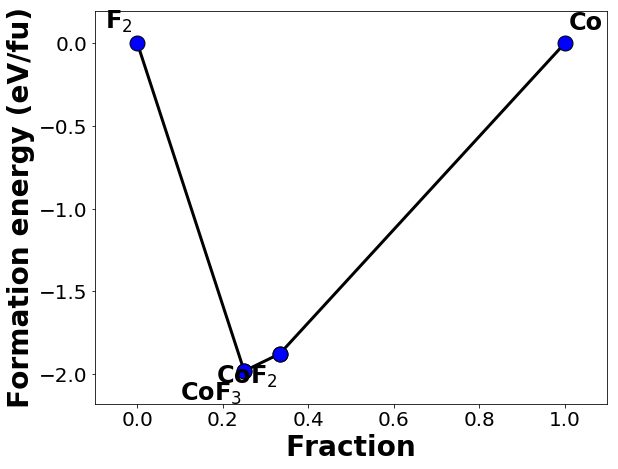

In [28]:
pdg = PhaseDiagram(get_data_from_system(oqmd_data, 
                                        binary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[3])
                  ['pdentry'])
PDPlotter(pdg).show()

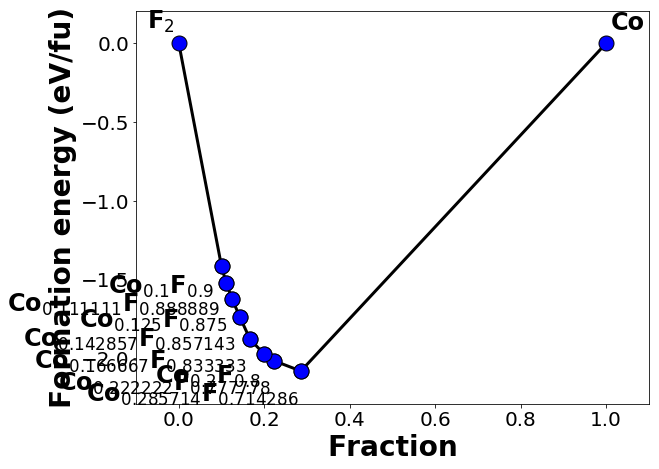

In [29]:
pdg = PhaseDiagram(get_data_from_system(updated_oqmd_data, 
                                        binary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[3])
                  ['pdentry'])
PDPlotter(pdg).show()

### Ternary Systems
Add in ternary data, reassess ternaries

Update the ternary systems

In [29]:
%%time
find_number_of_stable_compounds(ternary_systems, updated_oqmd_data, 'with_DL')
ternary_systems['new_compounds'] = ternary_systems['with_DL'] - ternary_systems['oqmd_stable']

Wall time: 21min 32s


Plot which have the most numbers of new compounds

In [30]:
ternary_systems.sort_values('new_compounds', ascending=False).head()

,system,oqmd_stable,with_DL,new_compounds
73255,"(Te, Br, Na)",8,26,18
64593,"(F, K, P)",9,27,18
64544,"(F, Na, As)",8,26,18
64473,"(F, Si, K)",8,26,18
74498,"(Li, Rh, P)",11,29,18


C:\Users\Logan\Miniconda2\envs\python3\lib\site-packages\numpy\linalg\linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


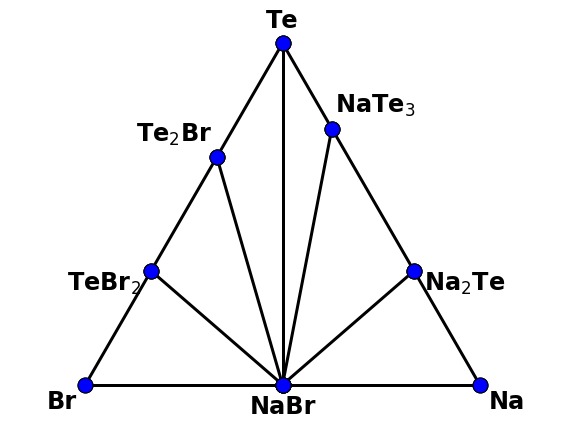

In [31]:
pdg = PhaseDiagram(get_data_from_system(oqmd_data, 
                                        ternary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[0])
                  ['pdentry'])
PDPlotter(pdg).show()

C:\Users\Logan\Miniconda2\envs\python3\lib\site-packages\numpy\linalg\linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


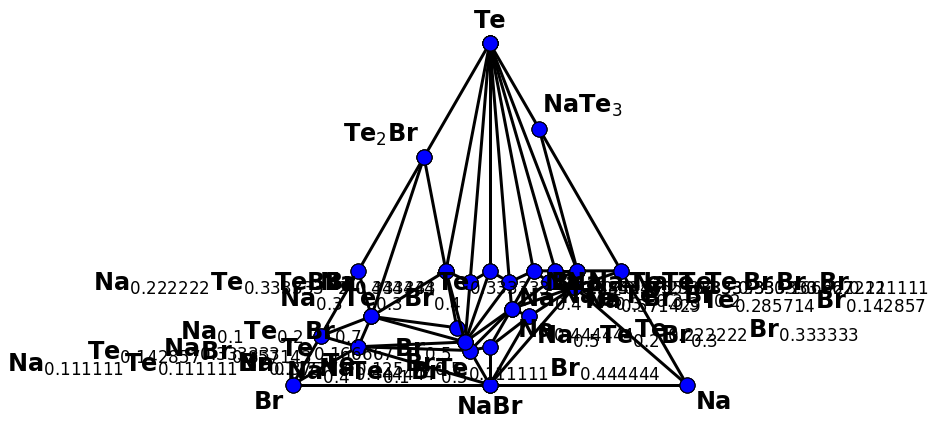

In [32]:
pdg = PhaseDiagram(get_data_from_system(updated_oqmd_data, 
                                        ternary_systems.sort_values('new_compounds', ascending=False)['system'].tolist()[0])
                  ['pdentry'])
PDPlotter(pdg).show()

In [33]:
ternary_systems.to_csv('ternary_systems.csv', index=False)

## Quaternary Systems
Same thing, but with quaternaries

In [34]:
%%time
updated_oqmd_data = updated_oqmd_data.append(load_DL_predictions(os.path.join('new-datasets', 'quaternary_stable-0.2.data.gz')))

Wall time: 37min 27s


Update the counts of stable compounds

In [35]:
%%time
find_number_of_stable_compounds(quaternary_systems, updated_oqmd_data, 'with_DL')
quaternary_systems['new_compounds'] = quaternary_systems['with_DL'] - quaternary_systems['oqmd_stable']

Wall time: 18h 39min 58s


In [36]:
quaternary_systems.sort_values('new_compounds', ascending=False).head()

,system,oqmd_stable,with_DL,new_compounds
1196690,"(Mn, Fe, Ti, P)",24,70,46
552858,"(Se, Ni, Zn, Ti)",25,60,35
1156328,"(Sc, Co, Zn, P)",23,58,35
234876,"(Cu, N, Mn, Zn)",11,45,34
1166769,"(Sc, V, Zn, Br)",15,49,34


In [37]:
quaternary_systems.to_csv('quaternary_systems.csv', index=False)